In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADSAR_MODEL_STATE_DICT_PATH=os.getenv("RADSAR_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_radar_processing.processors.synthetic_array_beamformer_processor_revA import SyntheticArrayBeamformerProcessor

from mmwave_model_integrator.input_encoders.radsar_encoder import RadSAREncoder
from mmwave_model_integrator.ground_truth_encoders.radsar_gt_encoder import RadSarGTEncoder
from mmwave_model_integrator.plotting.plotter_radsar import PlotterRadSar
from mmwave_model_integrator.dataset_generators.radsar_dataset_generator import RadSARDatasetGenerator

from mmwave_model_integrator.model_runner.radsar_runner import RadSARRunner
from mmwave_model_integrator.decoders.radsar_decoder import RadSARDecoder
from mmwave_model_integrator.plotting.movie_generator_radsar import MovieGeneratorRadSAR
from mmwave_model_integrator.analyzers.analyzer_radsar import AnalyzerRadSAR
from mmwave_model_integrator.transforms.coordinate_transforms import polar_to_cartesian


/home/david/.cache/pypoetry/virtualenvs/mmwave-model-integrator-S4Y7oiM5-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#load the dataset
#determine the paths to all of the datasets
dataset_name = "NORTH_RadSAR_Test_1"
dataset_path = os.path.join(MODEL_TRAINING_DATASET_PATH,"RadSAR",dataset_name)

dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full",
    vehicle_odom_folder="vehicle_odom"
)

found 304 radar samples
found 304 lidar samples
found 304 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 304 vehicle velocity samples
found 304 vehicle odometry samples


In [4]:
plotter = PlotterRadSar()

input_encoder = RadSAREncoder(
    config_manager=cfg_manager,
    az_angle_bins_rad=\
        np.deg2rad(np.linspace(
            start=-70,stop=70,num=90
            )),
    min_vel=0.2,
    max_vel_change=0.1,
    mode = SyntheticArrayBeamformerProcessor.ENDFIRE_MODE,
    min_power_threshold_dB=40
)

ground_truth_encoder = RadSarGTEncoder(
    max_range_m=cfg_manager.range_max_m,
    num_range_bins=cfg_manager.get_num_adc_samples(),
    angle_range_rad=[np.deg2rad(-60),np.deg2rad(60)],
    num_angle_bins=90,
    num_previous_frames=0
)

runner = RadSARRunner(
    state_dict_path=RADSAR_MODEL_STATE_DICT_PATH,
    cuda_device="cpu"
)


prediction_decoder = RadSARDecoder(
    max_range_m=cfg_manager.range_max_m,
    num_range_bins=cfg_manager.get_num_adc_samples(),
    angle_range_rad=[np.deg2rad(-60),np.deg2rad(60)],
    num_angle_bins=90
)

movie_generator = MovieGeneratorRadSAR(
    cpsl_dataset=dataset,
    plotter=plotter,
    input_encoder=input_encoder,
    runner=runner,
    decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.path.join(os.getenv("MOVIE_TEMP_DIRECTORY"),"radSAR")
)

analyzer = AnalyzerRadSAR(
    cpsl_dataset=dataset,
    input_encoder=input_encoder,
    model_runner=runner,
    prediction_decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("ANALYZER_TEMP_DIRECTORY")
)

alpha: 6.968355977686613 (mag), 16.86260656902793 dB
_ModelRunner: using CPU
Total number of parameters: 7701825
found temp dir: /home/david/Downloads/mmwave_model_integrator_temp/radSAR
clearing temp directory /home/david/Downloads/mmwave_model_integrator_temp/radSAR


In [5]:
#go until the encoder is ready
idx = 0
while not input_encoder.full_encoding_ready:

    try: #try accessing the full odometry data
        vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
    except AssertionError: #if not just get the x velocity (forward)
        vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
        vel_data = np.array([vel,0,0])
    
    adc_cube = dataset.get_radar_data(idx)
    
    resp = input_encoder.encode(
        adc_data_cube=adc_cube,
        vels=vel_data
    )
    idx += 1

print(idx)

96


In [6]:
#evaluating the model on standard inputs
adc_cube = dataset.get_radar_data(idx)
try: #try accessing the full odometry data
    vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
except AssertionError: #if not just get the x velocity (forward)
    vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
    vel_data = np.array([vel,0,0])

rng_az_resp = input_encoder.encode(
    adc_data_cube=adc_cube,
    vels=vel_data
)

if input_encoder.full_encoding_ready:
    pred = runner.make_prediction(input=rng_az_resp)

    pc = prediction_decoder.convert_polar_to_cartesian(
        prediction_decoder.decode(pred)
    )

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx)
grid = ground_truth_encoder.encode(lidar_pc)
quantized_pc = ground_truth_encoder.grid_to_polar_points(grid)
quantized_pc = polar_to_cartesian(quantized_pc)

#getting camera data
try:
    camera_view = dataset.get_camera_frame(idx)
except AssertionError:
    camera_view = np.empty(shape=(0))

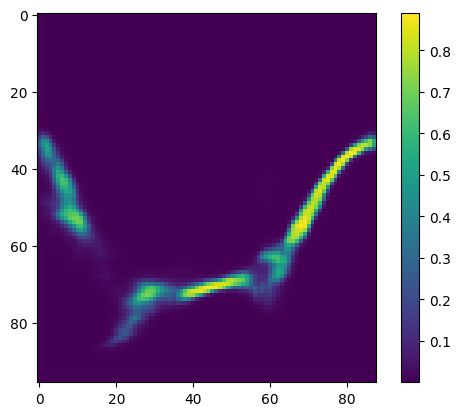

In [7]:
raw_resp_raw = runner.make_prediction_raw(rng_az_resp)
plt.imshow(raw_resp_raw)
plt.colorbar()

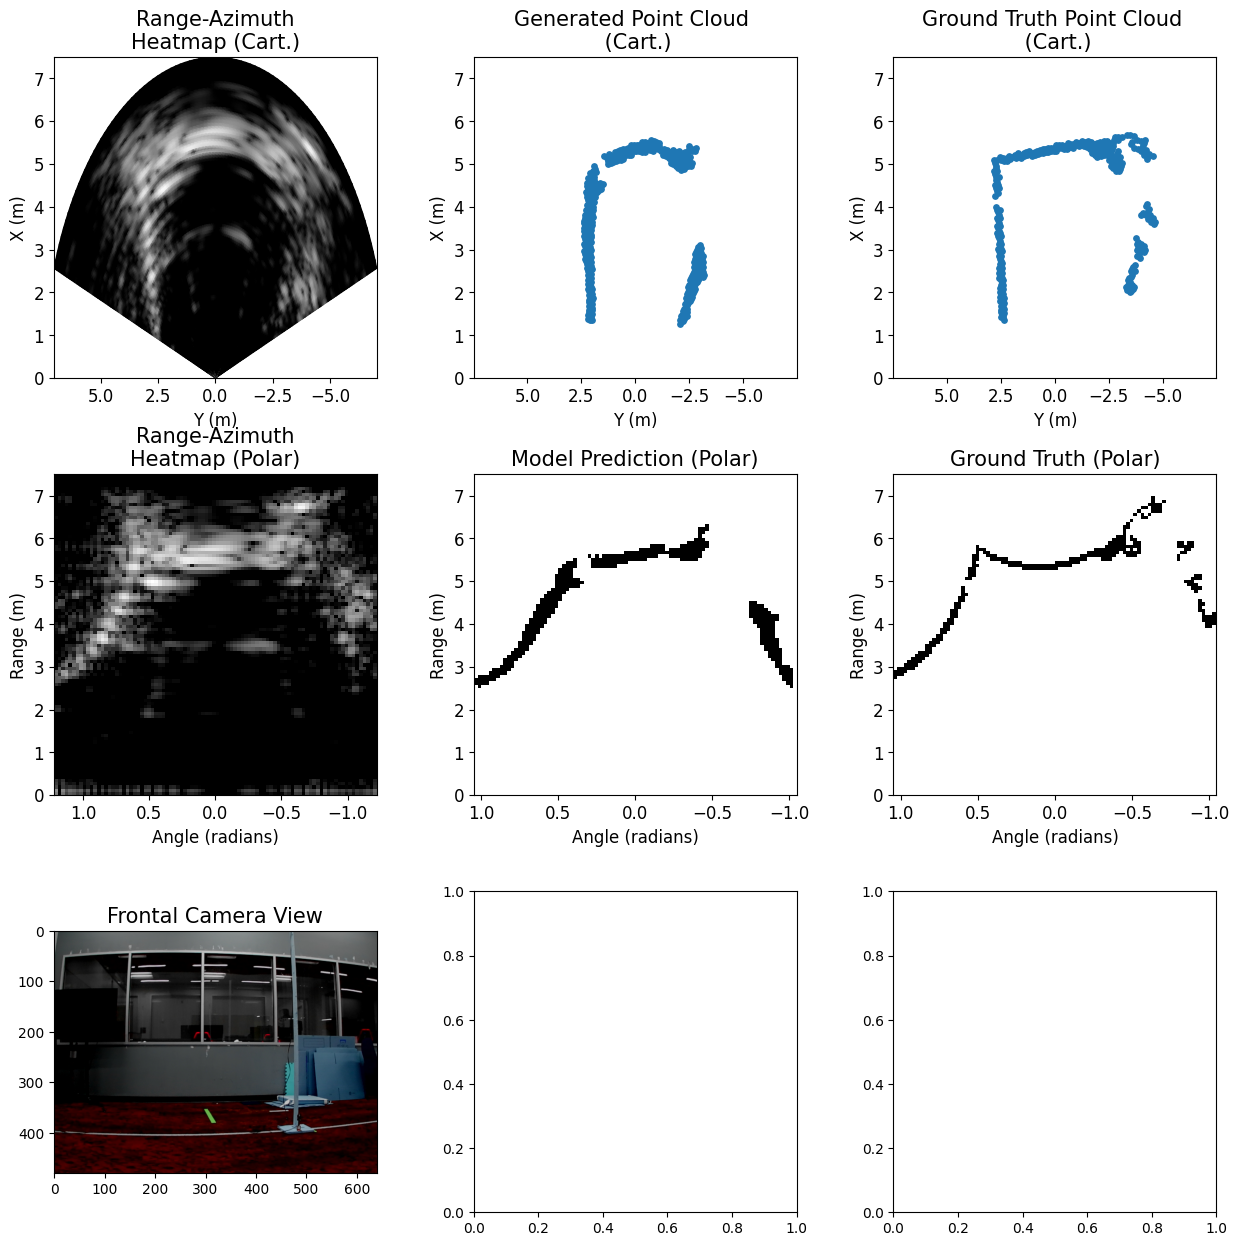

In [8]:
plotter.plot_compilation(
    input_adc_cube=adc_cube,
    input_vels=vel_data,
    input_encoder=input_encoder,
    runner=runner,
    decoder=prediction_decoder,
    gt_data=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    camera_view=camera_view,
    axs=[],
    show=True
)

In [9]:
# #speed comparison
# from tqdm import tqdm

# for i in tqdm(range(dataset.num_frames)):

#     adc_cube = dataset.get_radar_data(idx=1)
#     try: #try accessing the full odometry data
#         vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
#     except AssertionError: #if not just get the x velocity (forward)
#         vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
#         vel_data = np.array([vel,0,0])
#     rng_az_resp = input_encoder.encode(adc_cube,vel_data)
#     if input_encoder.full_encoding_ready:
#         pred = runner.make_prediction(input=rng_az_resp)
#         pc = prediction_decoder.convert_polar_to_cartesian(
#             prediction_decoder.decode(pred)
#         )

In [10]:
chamfer,hausdorff, chamfer_radarHD, modified_hausdorff_radarHD = \
    analyzer.compute_all_distance_metrics(
        save_to_file=False,
        file_name=dataset_name
    )
analyzer.show_all_summary_statistics(
    chamfer_distances=chamfer,
    hausdorff_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_radarHD,
    modified_hausdorff_distances_radarHD=modified_hausdorff_radarHD
)

Analyzer.compute_all_distance_metrics: Computing distance metrics


  1%|▏         | 3/208 [00:00<00:09, 22.57it/s]

100%|██████████| 208/208 [00:04<00:00, 42.79it/s]

Analyzer.compute_all_distance_metrics: number failed predictoins 0 of 208 (0.0%)


,Metric,Hausdorff,Modified Hausdorff (radarHD),Chamfer,Chamfer (radarHD)
0,Mean,2.368709,0.154732,0.365512,0.233428
1,Median,2.226862,0.151410,0.317704,0.223071
2,90th percentile,3.062224,0.224423,0.567992,0.305784


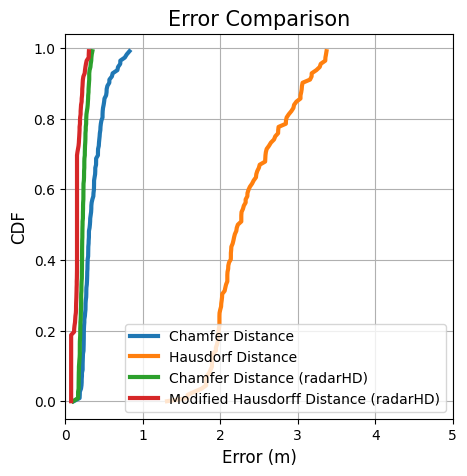

In [12]:
plotter.plot_distance_metrics_cdfs(
    chamfer_distances=chamfer,
    hausdorf_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_radarHD,
    modified_hausdorf_distances_radarHD=modified_hausdorff_radarHD
)

100%|██████████| 208/208 [00:26<00:00,  7.91it/s]


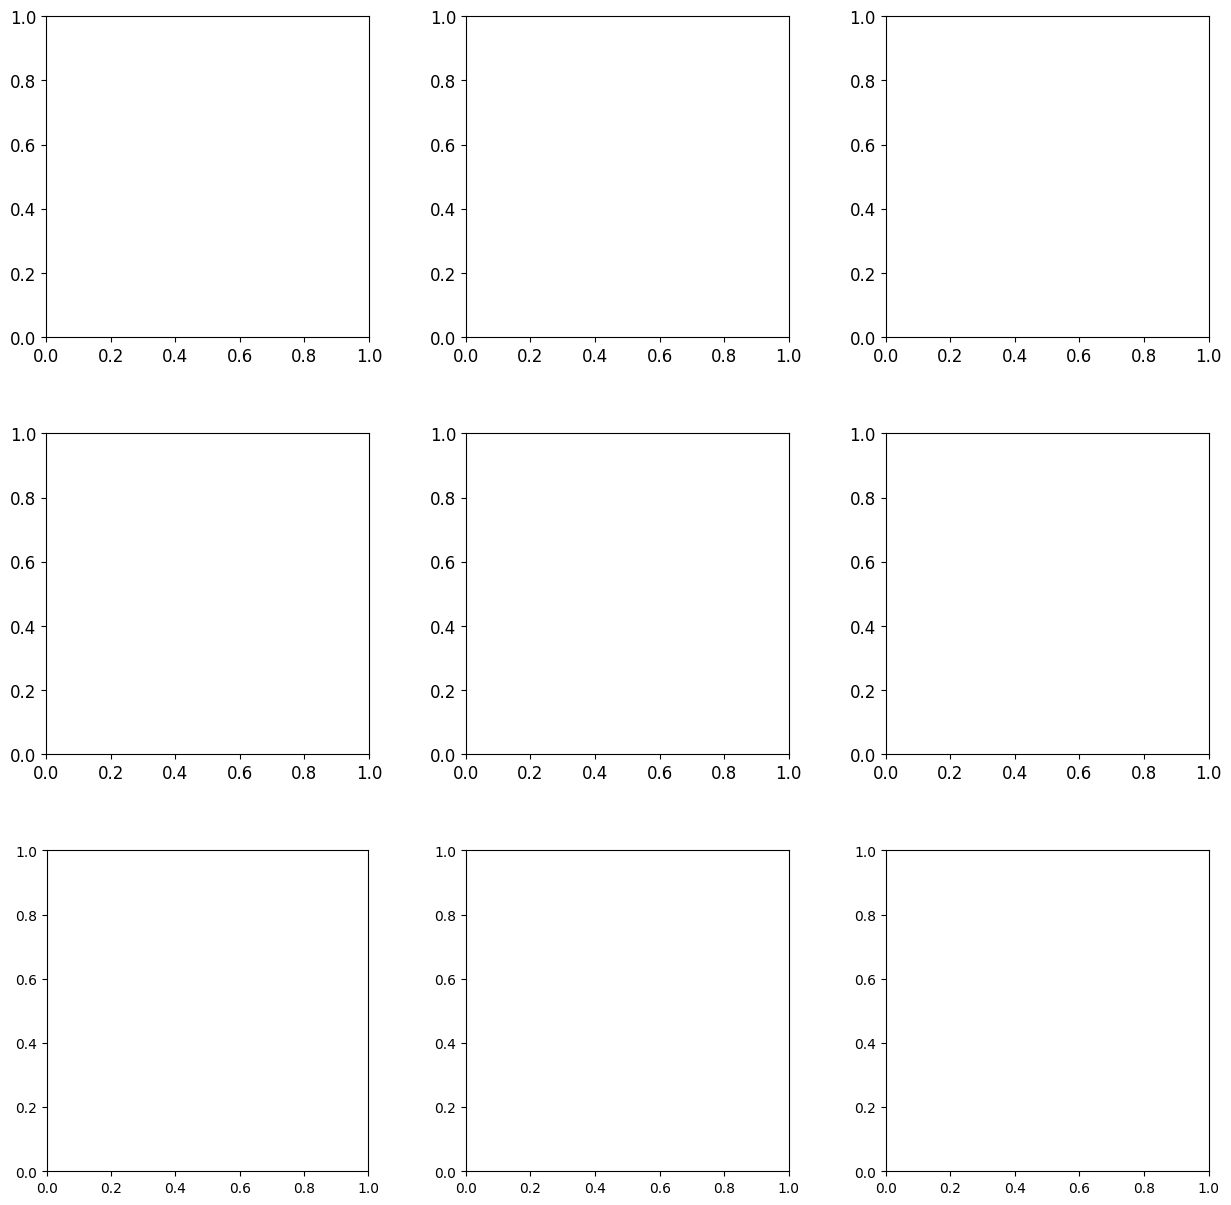

In [13]:
movie_generator.initialize_figure(
    nrows=3,
    ncols=3,
    figsize=(15,15),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_test.mp4".format(dataset_name),fps=fps)